# Imbalanced Data

## Apa itu Imbalanced Data?

**Imbalanced data** adalah kondisi ketika jumlah sampel antar kelas dalam sebuah dataset tidak seimbang secara signifikan. Artinya, terdapat kelas dengan jumlah data yang jauh lebih banyak (*kelas mayoritas*) dibandingkan dengan kelas yang memiliki jumlah data jauh lebih sedikit (*kelas minoritas*).

### Contoh Sederhana:
- Dataset transaksi keuangan: **95%** transaksi normal dan hanya **5%** transaksi penipuan.
- Dataset kesehatan: **90%** pasien sehat dan hanya **10%** pasien sakit.

### Kasus Dunia Nyata:
Kondisi seperti ini sering muncul dalam berbagai bidang, seperti:
- **Deteksi Penipuan (Fraud Detection)**: Transaksi normal vs transaksi penipuan.
- **Kesehatan**: Pasien sehat vs penyakit langka.
- **Keamanan Siber**: Trafik normal vs serangan.
- **Manufaktur**: Produk normal vs produk cacat.


### Mengapa Imbalanced Data menjadi masalah?

Pada dataset yang tidak seimbang, model cenderung bias ke kelas mayoritas.  
Misalnya, jika **95%** data adalah "normal", model bisa mencapai akurasi **95%** hanya dengan selalu menebak "normal" tanpa pernah mengenali "penipuan".


#### Masalah Utama yang Muncul:

1. **Akurasi Menipu**  
    Nilai akurasi tinggi, tetapi sebenarnya model tidak mampu mengenali kelas minoritas.

2. **Sulit Mendeteksi Pola Penting**  
    Kelas minoritas biasanya lebih kritis (contoh: kasus penipuan atau penyakit).

3. **Evaluasi Model Tidak Valid**  
    Metrik seperti *accuracy* kurang tepat; lebih cocok menggunakan *precision*, *recall*, *F1-score*, atau *ROC-AUC*.

### Cara Mengatasi Imbalanced Data:

#### 1. Resampling Data
- **Oversampling**: Menambah jumlah data pada kelas minoritas, misalnya dengan teknik **SMOTE**.  
- **Undersampling**: Mengurangi jumlah data pada kelas mayoritas.

#### 2. Modifikasi Algoritma
- Menggunakan algoritma yang peka terhadap ketidakseimbangan data, seperti **class-weighted models**.

#### 3. Pemilihan Metrik Evaluasi yang Tepat
- Menggunakan **precision**, **recall**, **F1-score**, atau **ROC-AUC** untuk menilai performa model.


## Mengatasi data tidak seimbang menggunakan SMOTE

In [18]:
%pip install -q pandas matplotlib seaborn sqlalchemy psycopg2 scikit-learn imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

## Query data dari database

pada kode dibawah ini kita akan membaca dataset bunga Iris langsung dari database PostgreSQL ke dalam sebuah DataFrame Pandas menggunakan query SQL. Setelah data dimuat, kita menampilkan lima baris pertama menggunakan fungsi `.head()` untuk memastikan data telah terbaca dengan benar dan untuk mendapatkan gambaran awal mengenai struktur dan isinya

In [20]:
host = 'localhost'
port = '5432'
password = 'root'
usn = 'postgres'

conn = create_engine(f"postgresql+psycopg2://{usn}:{password}@{host}:{port}/iris-full")

# KODE INI BERLAKU JIKA DATASET ADA PADA CLOUD
# query = """
# (SELECT * FROM iris_full WHERE class = 'Iris-setosa' LIMIT 15)
# UNION ALL
# (SELECT * FROM iris_full WHERE class IN ('Iris-virginica', 'Iris-versicolor'));
# """

# iris_modified = pd.read_sql(query,conn)
# iris_modified.to_csv("csv/iris-unbalanced.csv", index=False)

iris_modified = pd.read_csv('csv/iris-unbalanced.csv')

iris_modified.head()

,id,class,petal length,petal width,sepal length,sepal width
0,1,Iris-setosa,1.4,0.2,5.1,3.5
1,2,Iris-setosa,1.4,0.2,4.9,3.0
2,3,Iris-setosa,1.3,0.2,4.7,3.2
3,4,Iris-setosa,1.5,0.2,4.6,3.1
4,5,Iris-setosa,1.4,0.2,5.0,3.6


## Visualisasi Dataset 

Untuk memahami karakteristik data lebih dalam, terutama terkait ketidakseimbangan kelas, kita melakukan visualisasi pada sel keempat. Sebuah scatter plot dibuat menggunakan Seaborn untuk memetakan distribusi data berdasarkan fitur `petal length` dan `petal width`. Setiap spesies bunga diberi warna yang berbeda, sehingga kita dapat dengan mudah melihat pengelompokan visualnya. Dari plot ini, terlihat jelas bahwa jumlah sampel untuk kelas `Iris-setosa` jauh lebih sedikit dibandingkan dua kelas lainnya. Total data sebanyak 115 sampel juga dikonfirmasi, yang memperkuat temuan bahwa dataset ini memang tidak seimbang dan memerlukan penanganan khusus.

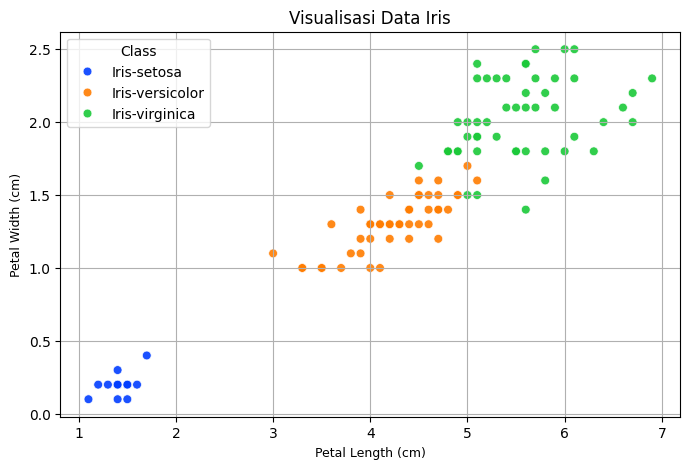

115


<Figure size 640x480 with 0 Axes>

In [21]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=iris_modified,
    x="petal length",
    y="petal width",
    hue="class",
    palette="bright",
    markers="o",
    s=40,
    alpha=0.9
)
plt.title("Visualisasi Data Iris", fontsize=12)
plt.xlabel("Petal Length (cm)", fontsize=9)
plt.ylabel("Petal Width (cm)", fontsize=9)
plt.legend(title="Class")
plt.grid(True)
plt.show()
plt.clf()
print(len(iris_modified))

## Reduksi Dimensi 

Meskipun dataset Iris hanya memiliki empat fitur, memvisualisasikannya dalam empat dimensi secara bersamaan tidaklah mungkin. Oleh karena itu, pada sel kelima dan keenam, kita menerapkan teknik Principal Component Analysis (**PCA**). PCA membantu mereduksi keempat fitur menjadi dua komponen utama (`PC-1` dan `PC-2`) yang paling mampu merepresentasikan variasi dalam data. Setelah transformasi, kita kembali membuat scatter plot menggunakan dua komponen utama ini. Hasilnya menunjukkan bahwa ketiga kelas bunga tetap terpisah dengan baik, menandakan bahwa pola yang signifikan dalam data dapat ditangkap bahkan dalam ruang dimensi yang lebih rendah.

In [22]:
X = iris_modified[["petal length","petal width","sepal length","sepal width"]]
y = iris_modified[["class"]]

pca = PCA(n_components=2)
x_pca = pca.fit_transform(X)

df_pca = pd.DataFrame(x_pca, columns=["PC-1", "PC-2"])
df_pca["class"] = y

print(df_pca)

         PC-1      PC-2           class
0    3.428204  0.700539     Iris-setosa
1    3.504360  0.232035     Iris-setosa
2    3.673845  0.254276     Iris-setosa
3    3.546718  0.067487     Iris-setosa
4    3.471126  0.698632     Iris-setosa
..        ...       ...             ...
110 -1.172083  0.138831  Iris-virginica
111 -0.702634 -0.350847  Iris-virginica
112 -0.981805  0.049720  Iris-virginica
113 -1.126136  0.010795  Iris-virginica
114 -0.577466 -0.302326  Iris-virginica

[115 rows x 3 columns]


## Visualisasi data setelah reduksi

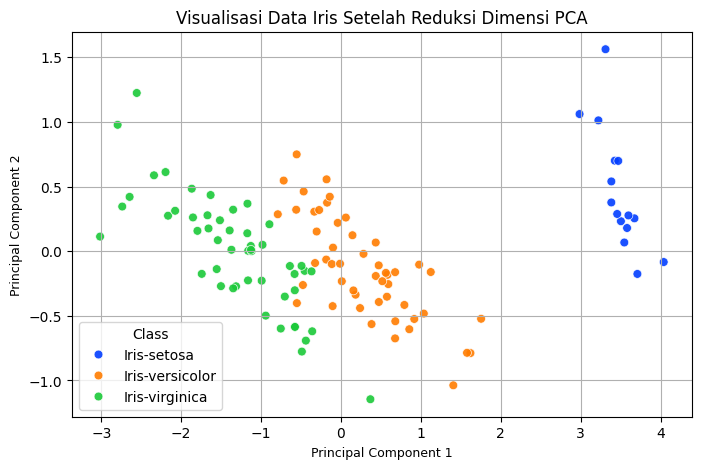

<Figure size 640x480 with 0 Axes>

In [23]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x="PC-1",
    y="PC-2",
    hue="class",
    data=df_pca,
    palette="bright",
    markers="o",
    s=40,
    alpha=0.9
)
plt.title("Visualisasi Data Iris Setelah Reduksi Dimensi PCA", fontsize=12)
plt.xlabel("Principal Component 1", fontsize=9)
plt.ylabel("Principal Component 2", fontsize=9)
plt.legend(title="Class")
plt.grid(True)
plt.show()  # Menampilkan plot secara langsung
plt.clf()

## Pembagian data dan implementasi SMOTE

Lalu kita memasuki tahap krusial dalam persiapan data untuk pemodelan. Pertama, dataset dibagi menjadi dua bagian: **70% data latih** dan **30% data uji**. Penggunaan parameter `stratify=y` memastikan bahwa proporsi kelas di kedua set data ini tetap sama seperti pada dataset asli.

Setelah pembagian, kita melihat distribusi kelas pada data latih, yang menunjukkan adanya ketidakseimbangan (35 `virginica`, 35 `versicolor`, dan hanya 10 `setosa`). Untuk mengatasi ini, kita menerapkan teknik SMOTE (Synthetic Minority Over-sampling Technique). SMOTE bekerja dengan cara membuat sampel sintetis untuk kelas minoritas (`Iris-setosa`) hingga jumlahnya setara dengan kelas mayoritas. Hasilnya, data latih kita menjadi seimbang sempurna, dengan masing-masing kelas kini memiliki 35 sampel. Penting dicatat bahwa SMOTE hanya diterapkan pada data latih untuk mencegah kebocoran informasi (data leakage) dari data uji.

In [ ]:
# Membagi data menjadi 70% data latih dan 30% data uji
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Menampilkan distribusi kelas sebelum SMOTE
print("Distribusi kelas sebelum SMOTE:")
print(y_train['class'].value_counts())
print("\n" + "="*30 + "\n")

# Menerapkan SMOTE pada data training
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Menampilkan distribusi kelas setelah SMOTE
print("Distribusi kelas setelah SMOTE:")
print(y_train_smote['class'].value_counts())

Distribusi kelas sebelum SMOTE:
class
Iris-virginica     35
Iris-versicolor    35
Iris-setosa        10
Name: count, dtype: int64


Distribusi kelas setelah SMOTE:
class
Iris-virginica     35
Iris-versicolor    35
Iris-setosa        35
Name: count, dtype: int64


## Pelatihan dan evaluasi model K-Nearest Neighbors (KNN)

Dengan data latih yang sudah bersih dan seimbang, kita siap untuk melatih model. Pada sel kedelapan, kita memilih algoritma K-Nearest Neighbors (KNN) dengan `k=5`, yang berarti model akan mempertimbangkan lima tetangga terdekat saat membuat prediksi. Model ini dilatih menggunakan data `X_train_smote` dan `y_train_smote`.

Setelah pelatihan selesai, performa model dievaluasi menggunakan data uji (`X_test` dan `y_test`) yang belum pernah dilihat sebelumnya. Hasil evaluasi menunjukkan akurasi sebesar **97.14%**, yang sangat baik. Laporan klasifikasi yang lebih rinci juga menunjukkan nilai precision, recall, dan f1-score yang tinggi untuk setiap kelas, menandakan bahwa model mampu mengklasifikasikan ketiga spesies bunga dengan sangat efektif.

In [25]:
# Membuat instance model KNN, kita coba dengan 5 tetangga (k=5)
knn_model = KNeighborsClassifier(n_neighbors=5)

# Melatih model menggunakan data training yang sudah di-oversampling
knn_model.fit(X_train_smote, y_train_smote.values.ravel())

# Melakukan prediksi pada data uji
y_pred_knn = knn_model.predict(X_test)

# Mengevaluasi performa model KNN
accuracy_knn = accuracy_score(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn)

print(f"Akurasi Model KNN: {accuracy_knn:.4f}")
print("\nLaporan Klasifikasi KNN:")
print(report_knn)

Akurasi Model KNN: 0.9714

Laporan Klasifikasi KNN:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         5
Iris-versicolor       1.00      0.93      0.97        15
 Iris-virginica       0.94      1.00      0.97        15

       accuracy                           0.97        35
      macro avg       0.98      0.98      0.98        35
   weighted avg       0.97      0.97      0.97        35



## Visualisasi Confusion Matrix

Sebagai langkah evaluasi akhir, pada sel kesembilan, kita membuat Confusion Matrix. Visualisasi ini memberikan gambaran yang jelas tentang performa model dengan menunjukkan jumlah prediksi yang benar dan yang salah untuk setiap kelas. Dengan menggunakan heatmap dari Seaborn, kita dapat dengan mudah menginterpretasikan hasilnya. Matriks ini mengonfirmasi bahwa dari 35 sampel data uji, hanya ada satu kesalahan klasifikasi, yaitu satu Iris-versicolor yang salah diprediksi sebagai Iris-virginica. Ini sekali lagi membuktikan bahwa model yang kita bangun memiliki performa yang solid dan andal.

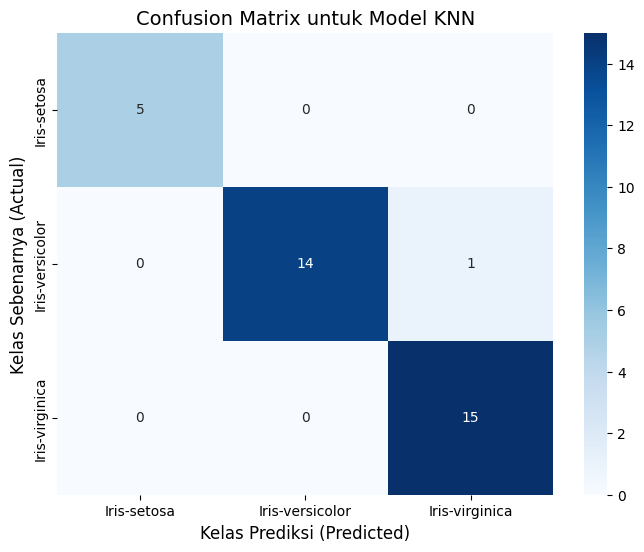

In [26]:
# Langkah 11: Impor library untuk confusion matrix dan visualisasinya
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Menghitung confusion matrix dari hasil prediksi KNN
cm = confusion_matrix(y_test, y_pred_knn)

# Mengambil nama kelas dari data asli untuk label pada plot
class_names = iris_modified['class'].unique()

# Membuat heatmap untuk visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix untuk Model KNN', fontsize=14)
plt.ylabel('Kelas Sebenarnya (Actual)', fontsize=12)
plt.xlabel('Kelas Prediksi (Predicted)', fontsize=12)
plt.show()